In [316]:
import bt
import pandas as pd
import tradingeconomics as te
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import numpy as np
from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import talib
pd.set_option("display.max_rows",1000)
te.login('75420451870E4F9:7C9E487641174F6')

'You are logged in as a 75420451870E4F9:7C9E487641174F6'

In [317]:
## Load data
def load_data(ticker, start = None, end = None, api=False):
    
    if api == False:
        data = pd.read_csv('C:\\Users\\utilizador\\PycharmProjects\\tss\\{}.csv'.format(ticker.replace(':','-')),
                               parse_dates=True, index_col=0)
        #if start is not None:
         #   data = data[data.index > start]
        #if start is not None:
         #   data = data[data.index < end]    
        
    else:
        try:
            df = te.getMarketsIntraday(symbols=ticker, initDate=start, endDate=end)        
            #df = df.drop('Symbol', axis=1)
            #df.index = df['Date']
            #df = df.drop('Date', axis=1)
            #print(df.head())
            data = pd.DataFrame(df['Close'].values, index=pd.to_datetime(df['Date'].values), columns=[ticker])
           
        except Exception as e:
            print(e,ticker)
        
    data.index.name = 'Date'
    data.columns = [ticker]
    data = data.iloc[::-1]
    return data
    

In [318]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights, zscore, zscore_high, zscore_low, hr):
        self.tw = target_weights
        self.zscore = zscore
        self.zscore_high = zscore_high
        self.zscore_low = zscore_low
        self.hr = hr        
        self.long_market = False
        self.short_market = False
        self.cache = 0
        
    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            z = self.tw.loc[target.now]            
            #print('zscores:', z)
            w = z
            ticker = target._universe_tickers[0]
            if z.ix[-1] <= -self.zscore_high and not self.long_market:
                w[ticker] = 0.2 * self.hr
                self.long_market = True
            elif abs(z.ix[-1]) <= self.zscore_low and self.long_market:
                w[ticker] = 0.0
                self.long_market = False
            elif z.ix[-1] >= self.zscore_high and not self.short_market:
                w[ticker] = -0.2 * self.hr
                self.long_market = True
            elif abs(z.ix[-1]) <= self.zscore_low and self.short_market:
                w[ticker] = 0.0
                self.short_market = False
            elif self.long_market == True:
                w[ticker] = self.cache
            elif self.short_market == True:    
                w[ticker] = self.cache
                
            self.cache = w    
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True
    

In [319]:
def pairs(main_ticker, aux_ticker, dependent=True, start='2018-04-01', end='2018-04-30', zscore_low=0.5, zscore_high=0.8, name='pairs'):
    # these are all the same steps as above
    #C:\Users\utilizador\PycharmProjects\tss\histdata\stocks_psi_geral\minimal\lig-pl_daily_minimal.csv
        
    df1 = load_data(main_ticker, start=start, end=end, api=True)    
    df2 = load_data(aux_ticker, start=start, end=end, api=True)        
    #comb_index = df1.index.union(df2.index)     
    comb_index = df1.index
    #df1.reindex(comb_index, method='ffill').fillna(method='ffill', inplace=True)
    #df2.reindex(comb_index, method='ffill').fillna(method='ffill', inplace=True)
    #print(len(df1),len(df2),len(df1.dropna()),len(df2.dropna()))
    
    beta_hr = sm.OLS(df1.values, df2.values).fit().params[0]    
    spread = df1.values - beta_hr * df2.values
    adf = ts.adfuller(spread.flatten())
    zscore_values = ((spread - spread.mean()) / spread.std())
    print('COINT: ', adf[0])
    #plot = bt.merge(pd.DataFrame(pd.Series(spread.flatten()), columns=['residuals']), 
     #               pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore'])).plot(figsize=(15,5))
                 
    # self.data[ticker].columns = [ticker]
    
    if dependent == True:
        hr = 1
        ticker = main_ticker
        df = df1.copy()
        tw = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore[ticker] = zscore_values
        tw[ticker] = np.zeros((1,len(comb_index))).flatten()
        #print(len(zscore), len(df1))
        #tw[ticker] = res
        #tw.columns = [ticker]
        tw[zscore[ticker] < -zscore_high] = 0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[zscore[ticker] > zscore_high] = -0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[df1.isnull()] = 0.0
        print('TICKER: {}, MAX: {}, MIN: {}, MEAN: {}, STD: {}, VARIANCE: {}'.format(ticker, max(zscore_values), min(zscore_values), 
                                                                                zscore_values.mean(), zscore_values.std(), np.power(zscore_values.std(), 2)))    
  
    else:
        hr = -beta_hr
        ticker = aux_ticker
        df = df2.copy()
        tw = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore[ticker] = zscore_values        
        tw[ticker] = np.zeros((1,len(comb_index))).flatten()      
        tw[zscore[ticker] < -zscore_high] = -abs(beta_hr)*0.2       
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[zscore[ticker] > zscore_high] = abs(beta_hr)*0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0       
        tw[df2.isnull()] = 0.0
        print(tw[ticker].value_counts())
        plot = bt.merge(pd.DataFrame(pd.Series([-zscore_high for i in range(len(zscore_values))]), columns=['lower_bound']), 
                    pd.DataFrame(pd.Series([zscore_high for i in range(len(zscore_values))]), columns=['upper_bound']),
                    pd.DataFrame(pd.Series([zscore_low for i in range(len(zscore_values))]), columns=['middle_high']),
                    pd.DataFrame(pd.Series([-zscore_low for i in range(len(zscore_values))]), columns=['middle_low']),
                    pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore'])).plot(figsize=(15,5))
        pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore']).hist(bins=50)  
       
    tmp = bt.merge(tw)
    tmp.columns = ['tw-{}'.format(ticker)]
    ax = tmp.plot(figsize=(15,5))
    
    #tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
    #p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
    #p1.line(tmp.index.values, tmp['sma100'].values, color='green', legend='sma100')
    
    #p1.line(tmp.index.values, tmp['price'].values, color='brown', legend='price')
    #p1.line(tmp.index.values, tmp['sma21'].values, color='orange', legend='sma21')
    #p1.line(tmp.index.values, tmp['sma9'].values, color='red', legend='sma9')
    #p1.extra_y_ranges = {"Weights": Range1d(start=0, end=1.0)}
    #p1.add_layout(LinearAxis(y_range_name="Weights"), 'right')
    #p1.line(tmp.index.values, tmp['tw'].values, color='purple', legend='tw', y_range_name="Weights")
       
    #show(p1)
    tw[ticker] = zscore_values
    s = bt.Strategy(name, [WeighTarget(tw, zscore, zscore_high, zscore_low, hr), bt.algos.Rebalance()], [ticker])
    return bt.Backtest(s, df)


https://api.tradingeconomics.com/markets/intraday/AUDUSD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/CADCHF%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.7319489741192644
TICKER: AUDUSD:CUR, MAX: [2.16730615], MIN: [-1.76405141], MEAN: 4.5474735088646414e-17, STD: 1.0, VARIANCE: 1.0
https://api.tradingeconomics.com/markets/intraday/AUDUSD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/CADCHF%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.7319489741192644
 0.000000    5232
-0.199603    2591
 0.199603    2177
Name: CADCHF:CUR, dtype: int64
cadchf_pairs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00audusd_pairs
0% [############################# ] 100% | ETA: 00:00:00

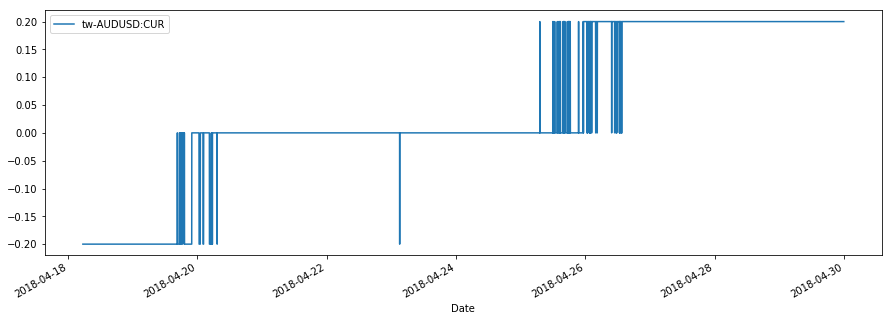

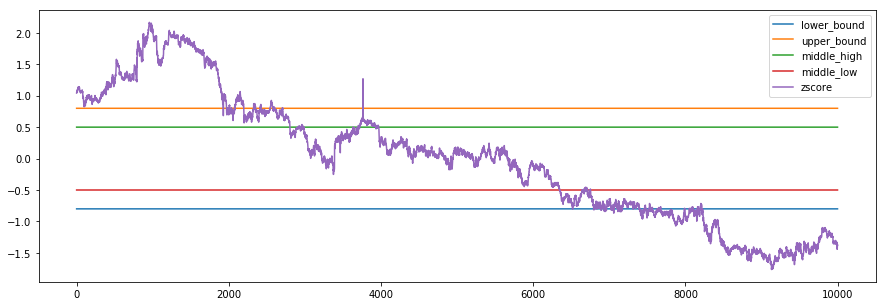

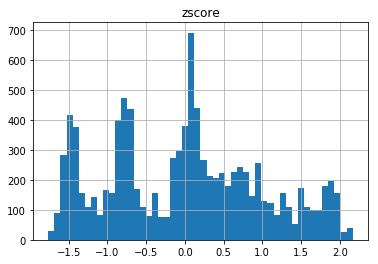

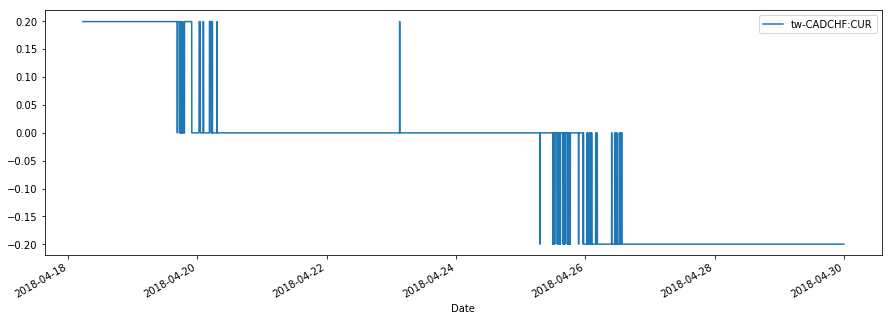

In [320]:
def run(selected_tickers, start=None, end=None):
    
    t1 = pairs('AUDUSD:CUR', 'CADCHF:CUR',  dependent=True, name='cadchf_pairs')
    t2 = pairs( 'AUDUSD:CUR','CADCHF:CUR', dependent=False, name='audusd_pairs')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

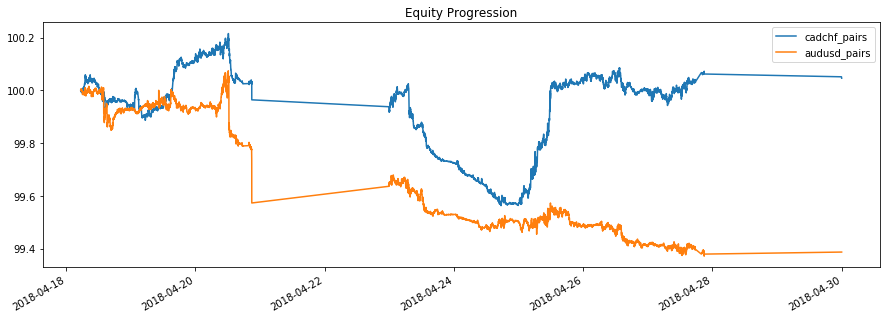

In [321]:
%matplotlib inline 
res.plot()

In [322]:
res.display()

Stat                 cadchf_pairs    audusd_pairs
-------------------  --------------  --------------
Start                2018-04-18      2018-04-18
End                  2018-04-30      2018-04-30
Risk-free rate       0.00%           0.00%

Total Return         0.05%           -0.61%
Daily Sharpe         0.80            -7.36
Daily Sortino        2.04            -7.78
CAGR                 3.03%           -15.28%
Max Drawdown         -0.56%          -0.55%
Calmar Ratio         5.45            -27.58

MTD                  -               -
3m                   -               -
6m                   -               -
YTD                  0.05%           -0.61%
1Y                   -               -
3Y (ann.)            -               -
5Y (ann.)            -               -
10Y (ann.)           -               -
Since Incep. (ann.)  3.03%           -15.28%

Daily Sharpe         0.80            -7.36
Daily Sortino        2.04            -7.78
Daily Mean (ann.)    2.52%           -13.71%


https://api.tradingeconomics.com/markets/intraday/USDSEK%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.18514713321770518
TICKER: USDSEK:CUR, MAX: [2.69693823], MIN: [-1.49905525], MEAN: 0.0, STD: 1.0, VARIANCE: 1.0
https://api.tradingeconomics.com/markets/intraday/USDSEK%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.18514713321770518
 0.000000    5729
-0.012825    2570
 0.012825    1701
Name: EURJPY:CUR, dtype: int64
cadchf_pairs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00usdsek_pairs
0% [############################# ] 100% | ETA: 00:00:00

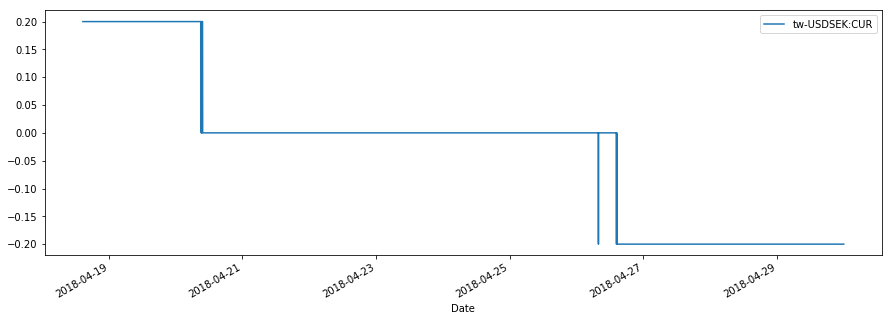

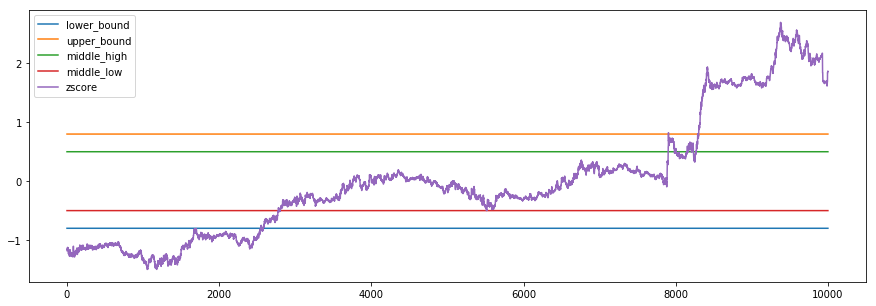

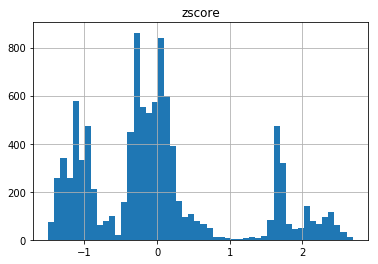

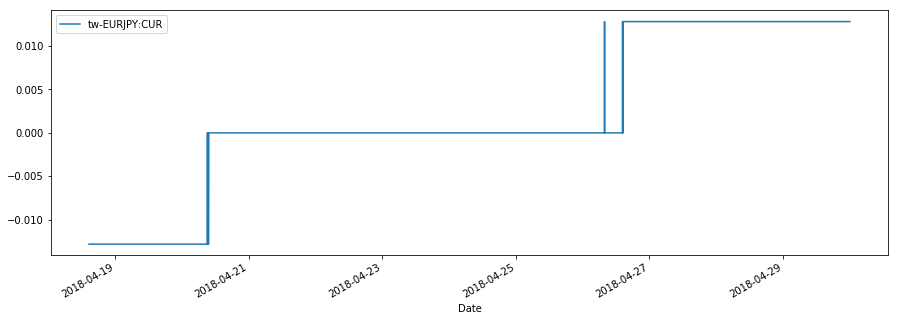

In [323]:
def run(selected_tickers, start=None, end=None):
    
    t1 = pairs('USDSEK:CUR', 'EURJPY:CUR',  dependent=True, name='cadchf_pairs')
    t2 = pairs('USDSEK:CUR','EURJPY:CUR', dependent=False, name='usdsek_pairs')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

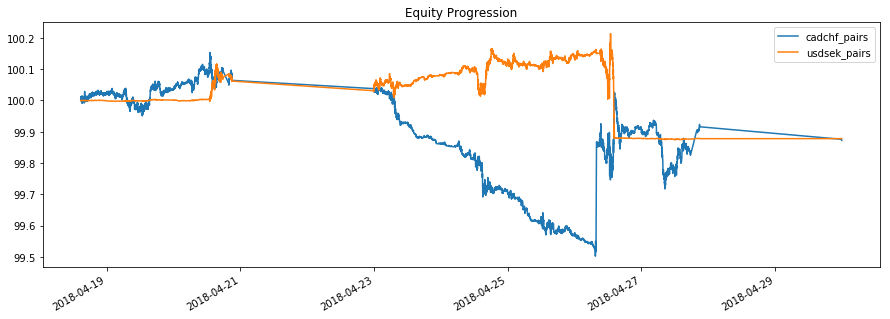

In [324]:
%matplotlib inline 
res.plot()

In [325]:
res.display()

Stat                 cadchf_pairs    usdsek_pairs
-------------------  --------------  --------------
Start                2018-04-18      2018-04-18
End                  2018-04-30      2018-04-30
Risk-free rate       0.00%           0.00%

Total Return         -0.13%          -0.12%
Daily Sharpe         -1.66           -2.08
Daily Sortino        -3.34           -2.32
CAGR                 -4.52%          -3.60%
Max Drawdown         -0.49%          -0.26%
Calmar Ratio         -9.14           -13.74

MTD                  -               -
3m                   -               -
6m                   -               -
YTD                  -0.13%          -0.12%
1Y                   -               -
3Y (ann.)            -               -
5Y (ann.)            -               -
10Y (ann.)           -               -
Since Incep. (ann.)  -4.52%          -3.60%

Daily Sharpe         -1.66           -2.08
Daily Sortino        -3.34           -2.32
Daily Mean (ann.)    -3.80%          -3.03%
Dai

https://api.tradingeconomics.com/markets/intraday/GBPJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -2.389745047893837
TICKER: GBPJPY:CUR, MAX: [2.29126576], MIN: [-2.5393487], MEAN: -2.2737367544323207e-17, STD: 1.0, VARIANCE: 1.0
https://api.tradingeconomics.com/markets/intraday/GBPJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -2.389745047893837
 0.000000    5440
 0.228816    2450
-0.228816    2110
Name: EURJPY:CUR, dtype: int64
GBPJPY_pairs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00EURJPY_pairs
0% [############################# ] 100% | ETA: 00:00:00

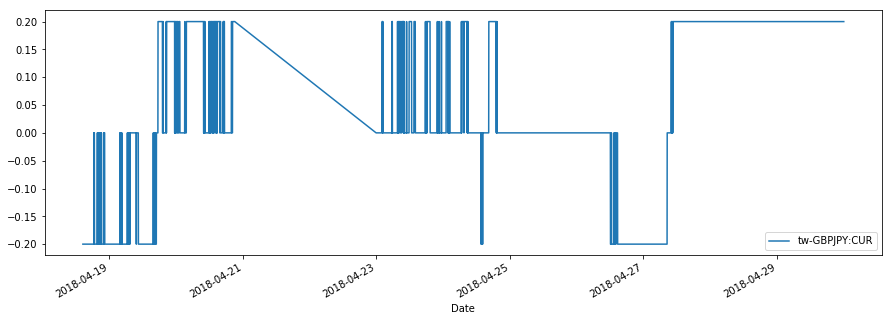

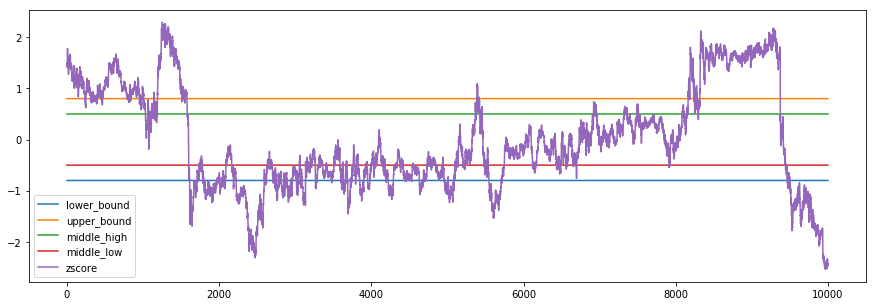

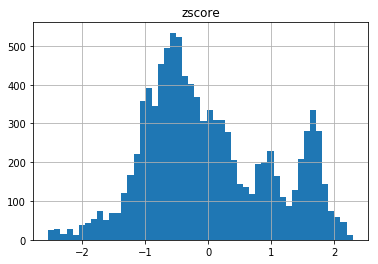

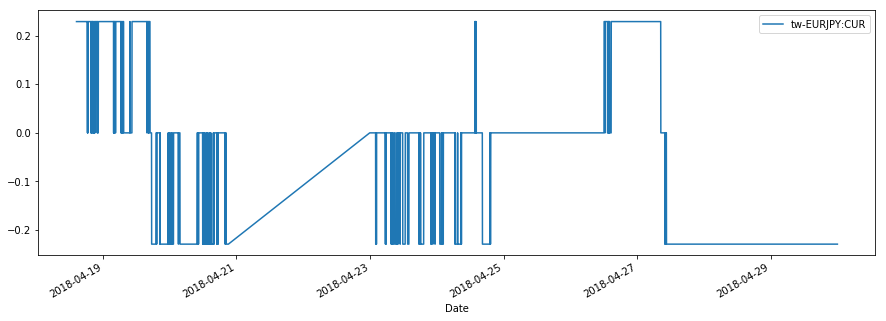

In [326]:
def run(selected_tickers, start=None, end=None):
    
    t1 = pairs('GBPJPY:CUR', 'EURJPY:CUR',  dependent=True, name='GBPJPY_pairs')
    t2 = pairs('GBPJPY:CUR','EURJPY:CUR', dependent=False, name='EURJPY_pairs')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

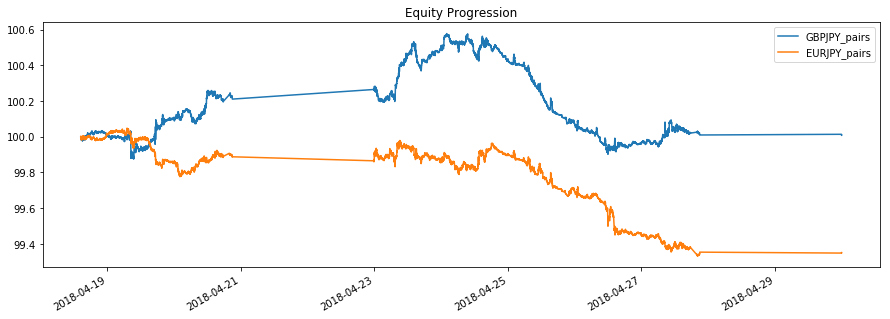

In [327]:
%matplotlib inline 
res.plot()

https://api.tradingeconomics.com/markets/intraday/USDSGD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURUSD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.9069756420310827
TICKER: USDSGD:CUR, MAX: [1.60111144], MIN: [-1.62688158], MEAN: 9.094947017729283e-17, STD: 1.0, VARIANCE: 1.0
https://api.tradingeconomics.com/markets/intraday/USDSGD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURUSD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -0.9069756420310827
 0.000000    4162
 0.215658    2999
-0.215658    2839
Name: EURUSD:CUR, dtype: int64
USDSGD_pairs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00EURUSD_pairs
0% [############################# ] 100% | ETA: 00:00:00

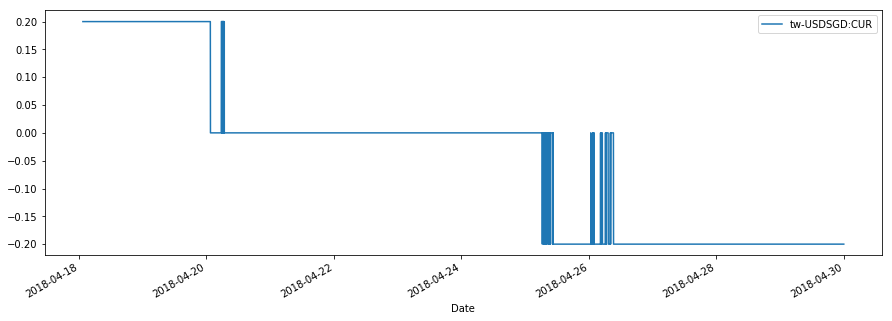

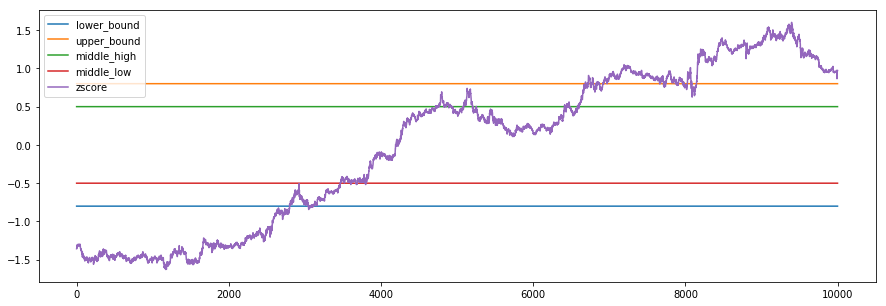

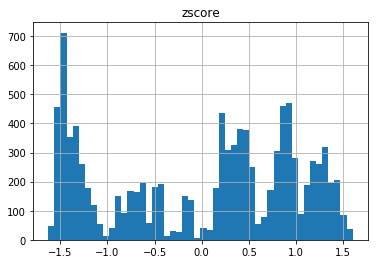

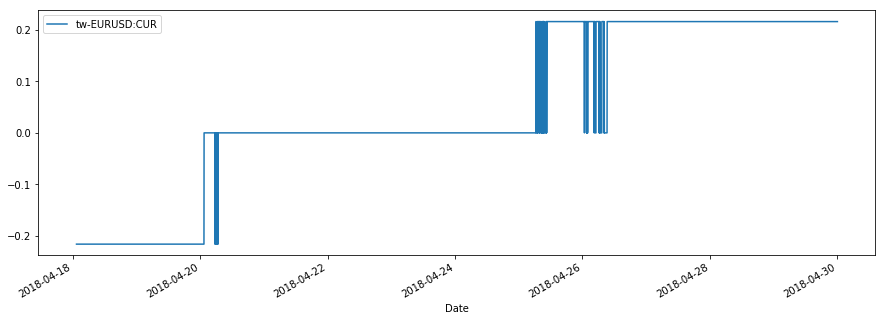

In [328]:
def run(selected_tickers, start=None, end=None):
    
    t1 = pairs('USDSGD:CUR', 'EURUSD:CUR',  dependent=True, name='USDSGD_pairs')
    t2 = pairs('USDSGD:CUR','EURUSD:CUR', dependent=False, name='EURUSD_pairs')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

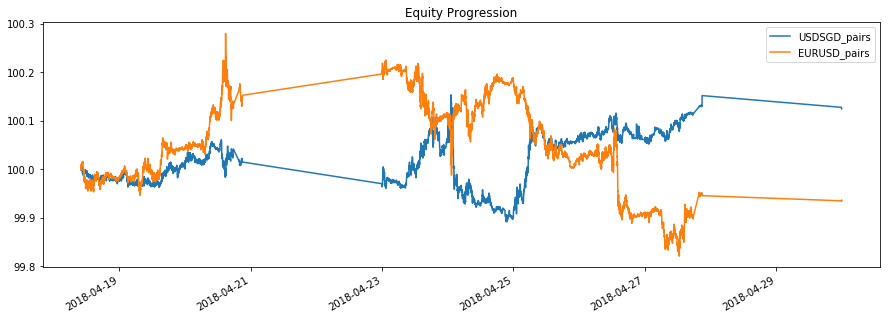

In [329]:
res.plot()

https://api.tradingeconomics.com/markets/intraday/USDNOK%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -1.01468172939609
TICKER: USDNOK:CUR, MAX: [2.21035263], MIN: [-1.82301863], MEAN: 0.0, STD: 0.9999999999999999, VARIANCE: 0.9999999999999998
https://api.tradingeconomics.com/markets/intraday/USDNOK%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
https://api.tradingeconomics.com/markets/intraday/EURJPY%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-04-01&d2=2018-04-30
COINT:  -1.01468172939609
 0.000000    5619
-0.011876    2556
 0.011876    1825
Name: EURJPY:CUR, dtype: int64
CHFJPY_pairs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00AUDCHF_pairs
0% [############################# ] 100% | ETA: 00:00:00

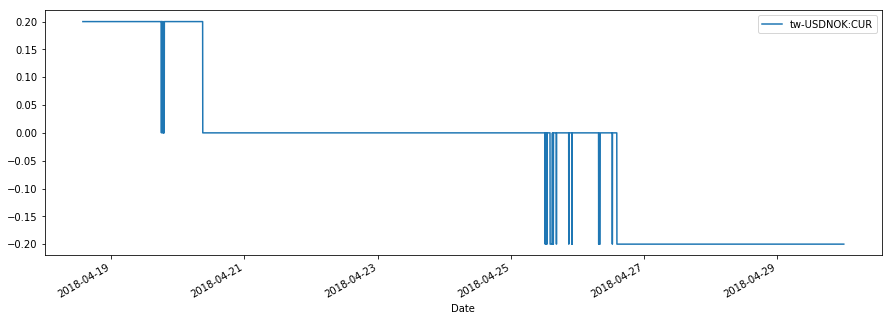

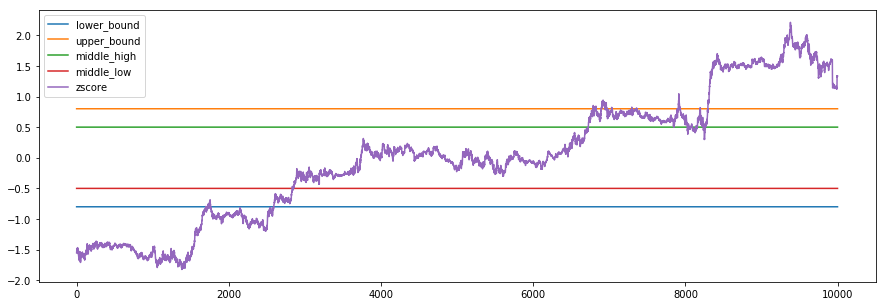

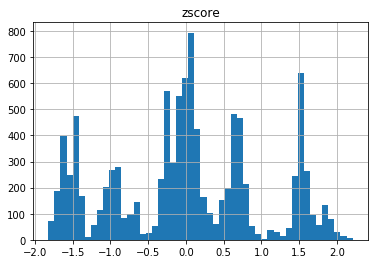

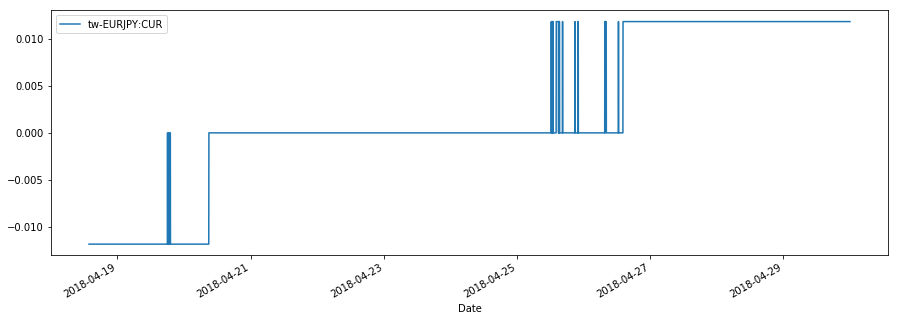

In [330]:
def run(selected_tickers, start=None, end=None):
    
    t1 = pairs('USDNOK:CUR', 'EURJPY:CUR',  dependent=True, name='CHFJPY_pairs')
    t2 = pairs('USDNOK:CUR', 'EURJPY:CUR', dependent=False, name='AUDCHF_pairs')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

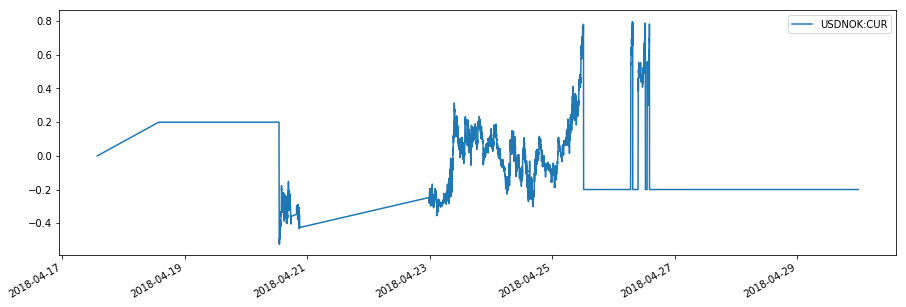

In [331]:
res.plot_security_weights()